<a href="https://colab.research.google.com/github/StacyChebet/Dyslexicon/blob/master/dyslexicon3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
#Mounting the google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
%cd /content/drive/MyDrive/Gambo (1)

/content/drive/MyDrive/Gambo (1)


In [38]:
#Importing modules
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import load_img, img_to_array
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import PIL
import PIL.Image
import tensorflow_datasets as tfds
import pathlib
import cv2
from keras.applications import ResNet152
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [39]:
train_path = '/content/drive/MyDrive/Gambo (1)/Train (1)'
test_path = '/content/drive/MyDrive/Gambo (1)/Test (1)'
val_path = '/content/drive/MyDrive/Gambo (1)/Validation (1)'

In [40]:
train_dir = pathlib.Path(train_path)
test_dir = pathlib.Path(val_path)

print(str(len(list(train_dir.glob('*/*.png'))) )+ ' Training Images')
print(str(len(list(test_dir.glob('*/*.png')))) + ' Testing Images')

1052 Training Images
449 Testing Images


In [41]:
batch_size = 32  
img_height = 224
img_width = 224

In [42]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split = 0.1,
    subset ='training',
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 1052 files belonging to 3 classes.
Using 947 files for training.


In [43]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split = 0.1,
    subset ='validation',
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 1052 files belonging to 3 classes.
Using 105 files for validation.


In [44]:
class_names = train_ds.class_names
print(class_names)

['Corrected (1)', 'Normal (1)', 'Reversal (1)']


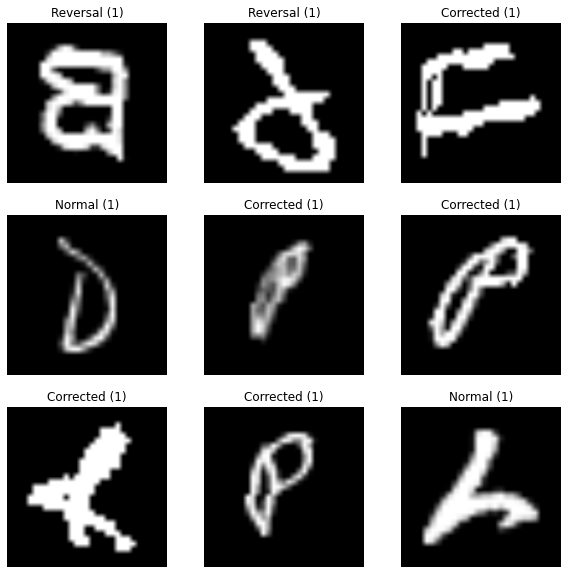

In [45]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [46]:
for image_batch, labels_batch in train_ds: #image batch is a tensor of the shape
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [47]:
num_classes = len(class_names)
print(num_classes)

3


In [48]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [49]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(img_height, img_width),
  layers.Rescaling(1./255)
])

In [50]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

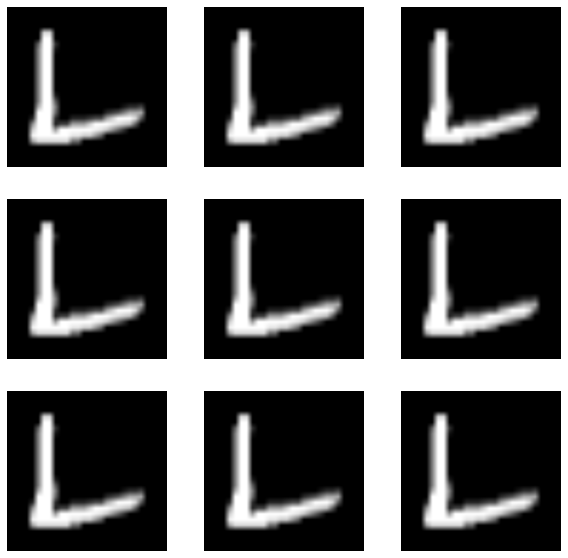

In [51]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [52]:
num_classes = len(class_names)
resnet_model = Sequential([
    resize_and_rescale,
  data_augmentation
])

pretrained_model= tf.keras.applications.ResNet152(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',classes= num_classes,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)

In [53]:
#Early stopping to avoid overfitting of model
# early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)

In [54]:
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(5, activation='softmax'))

In [55]:
resnet_model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                     metrics=['accuracy'])

In [61]:
epochs = 100
history = resnet_model.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=epochs, 
    shuffle=True)

Epoch 1/100
30/30 [==============================] - 8s 278ms/step - loss: 0.7356 - accuracy: 0.6610 - val_loss: 0.7598 - val_accuracy: 0.6286
Epoch 2/100
30/30 [==============================] - 8s 282ms/step - loss: 0.7621 - accuracy: 0.6505 - val_loss: 0.7330 - val_accuracy: 0.6571
Epoch 3/100
30/30 [==============================] - 8s 283ms/step - loss: 0.7342 - accuracy: 0.6737 - val_loss: 0.7347 - val_accuracy: 0.6190
Epoch 4/100
30/30 [==============================] - 9s 285ms/step - loss: 0.7371 - accuracy: 0.6600 - val_loss: 0.7085 - val_accuracy: 0.6381
Epoch 5/100
30/30 [==============================] - 9s 288ms/step - loss: 0.7559 - accuracy: 0.6621 - val_loss: 0.6919 - val_accuracy: 0.6095
Epoch 6/100
30/30 [==============================] - 9s 288ms/step - loss: 0.7570 - accuracy: 0.6684 - val_loss: 0.6900 - val_accuracy: 0.6286
Epoch 7/100
30/30 [==============================] - 9s 305ms/step - loss: 0.7277 - accuracy: 0.6779 - val_loss: 0.6924 - val_accuracy: 0.6286

# **Model Evaluation**

**Accuracy**

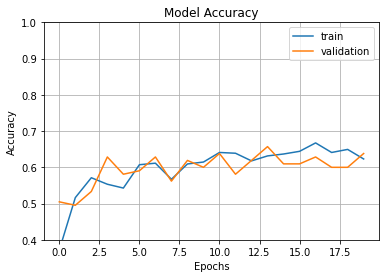

In [57]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

**Loss**

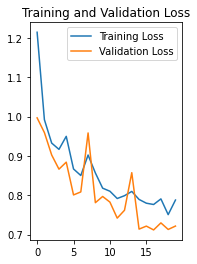

In [58]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# **Predictions**

**Normal Child**

In [68]:
#Normal Child Predictions
test_image = '/content/drive/MyDrive/Gambo (1)/Validation (1)/Reversal (1)/1_13436 (1).png'

img = tf.keras.utils.load_img(
    test_image, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = resnet_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 36ms/step
This image most likely belongs to Corrected (1) with a 32.28 percent confidence.


**Dyslexic Child**

In [66]:
#Dyslexic Child
test_image = '/content/drive/MyDrive/Gambo (1)/Validation (1)/Reversal (1)/1_13433 (1).png'

img = tf.keras.utils.load_img(
    test_image, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = resnet_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 34ms/step
This image most likely belongs to Corrected (1) with a 39.85 percent confidence.
